In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import sys
import os
import numpy as np

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2,
                                   rotation_range=30,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [3]:
training_set = train_datagen.flow_from_directory('../input/emotion-detection-fer/train',
                                                 target_size = (48, 48),
                                                 batch_size = 128,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical',
                                                 shuffle=True,subset = 'training')

validation_set = train_datagen.flow_from_directory('../input/emotion-detection-fer/test',
                                                 target_size = (48, 48),
                                                 batch_size = 128,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical',
                                                 shuffle=True,subset = 'validation')
test_set =test_datagen.flow_from_directory('../input/emotion-detection-fer/test',
                                                 target_size = (48, 48),
                                                 batch_size = 128,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(2048,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(7,activation='softmax'))

In [5]:
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [6]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=1,
                              min_delta=0.001)

callbacks = [earlystop,reduce_lr]


In [7]:
def focal_loss(alpha,gamma):
    def cal_loss(y_true,y_pred):
        y_true = tf.cast(y_true,dtype=tf.float32)
        y_pred = K.clip(y_pred,1e-5,1-1e-5)
        l = y_true*((1-y_pred)**gamma)*K.log(y_pred)
        l = -alpha*l
        return K.sum(l,axis=-1)
    return cal_loss
    

In [8]:
model.compile(loss=focal_loss(2.0,4.0),
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [9]:
history = model.fit(training_set,
         epochs =60,
          validation_data=validation_set)

Epoch 1/60
180/180 [==============================] - 195s 1s/step - loss: 3.5631 - accuracy: 0.1932 - val_loss: 4.0536 - val_accuracy: 0.1718
Epoch 2/60
180/180 [==============================] - 30s 167ms/step - loss: 2.1561 - accuracy: 0.2223 - val_loss: 2.9153 - val_accuracy: 0.0656
Epoch 3/60
180/180 [==============================] - 32s 176ms/step - loss: 2.0287 - accuracy: 0.2447 - val_loss: 2.7497 - val_accuracy: 0.1655
Epoch 4/60
180/180 [==============================] - 31s 174ms/step - loss: 1.8975 - accuracy: 0.2753 - val_loss: 2.1783 - val_accuracy: 0.2304
Epoch 5/60
180/180 [==============================] - 32s 177ms/step - loss: 1.8378 - accuracy: 0.2834 - val_loss: 2.2807 - val_accuracy: 0.2891
Epoch 6/60
180/180 [==============================] - 33s 182ms/step - loss: 1.7379 - accuracy: 0.3126 - val_loss: 1.7157 - val_accuracy: 0.2891
Epoch 7/60
180/180 [==============================] - 31s 171ms/step - loss: 1.7034 - accuracy: 0.3261 - val_loss: 1.6036 - val_accu

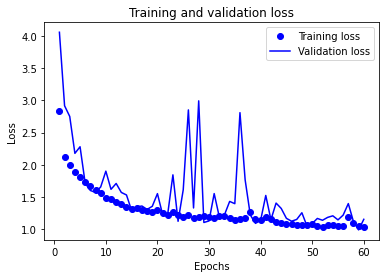

In [10]:
history_dict=history.history
import matplotlib.pyplot as plt

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

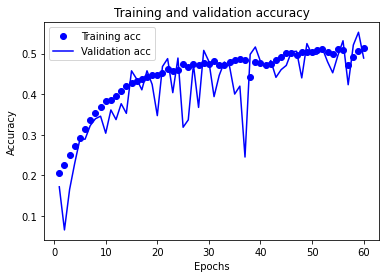

In [11]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
model.evaluate(test_set)

57/57 [==============================] - 42s 749ms/step - loss: 0.9312 - accuracy: 0.5646


[0.9311798810958862, 0.5646419525146484]